In [2]:
import pydicom ### read the dicom file
import os ### for directory operations
import pandas as pd # for data analysis

data_dir = 'c:/dataset/testing/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('c:/dataset/testing_labels.csv', index_col = 0)

labels_df.head()

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [6]:
### reading a single dicom file
for patient in patients[:1]:
    label = labels_df._get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(len(slices), label)
    print(slices[0])

195 1
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.7009.9004.321555830121981826540353244716
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.31'
-------------------------------------------------
(0008, 0000) Group Length                        UL: 358
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7009.9004.321555830121981826540353244716
(0008, 0060) Modality                            CS: 

In [3]:
### records of 10 patients
for patient in patients[:10]:
    label = labels_df._get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(len(slices), slices[0].pixel_array.shape)
    
### the depth of CT scans is different for different person
### size of the every CT image is huge (512 * 512 * depth)

195 (512, 512)
265 (512, 512)
233 (512, 512)
173 (512, 512)
146 (512, 512)
171 (512, 512)
123 (512, 512)
134 (512, 512)
135 (512, 512)
191 (512, 512)


In [4]:
len(patients)

1595

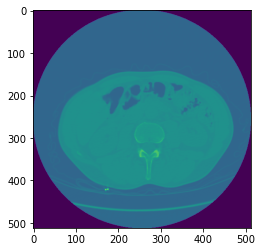

In [5]:
import matplotlib.pyplot as plt

### CT image visualization
for patient in patients[:1]:
    label = labels_df._get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    plt.imshow(slices[0].pixel_array)
    plt.show()

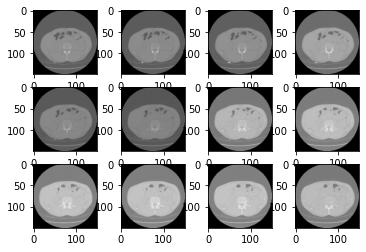

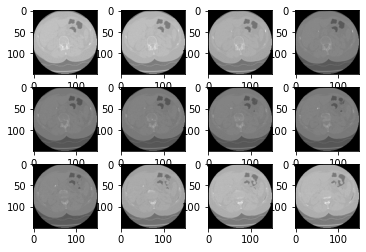

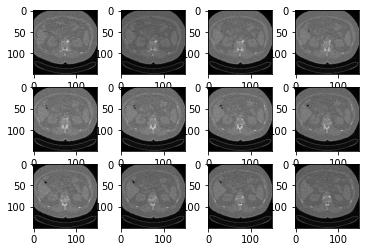

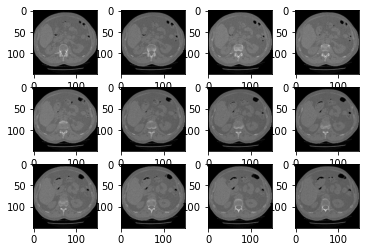

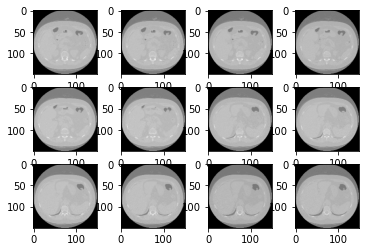

In [55]:
import cv2
import numpy as np

# constant
IMG_PX_SIZE = 150

### resize CT images
for patient in patients[:5]:
    label = labels_df._get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    fig = plt.figure()
    for num,each_slice in enumerate(slices[:12]):
        y = fig.add_subplot(3,4,num+1)
        new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE, IMG_PX_SIZE))
        y.imshow(new_img, cmap = plt.cm.gray)
    plt.show()

In [57]:
import cv2
import numpy as np
import math

### constant
IMG_PX_SIZE = 50
SLICE_COUNT = 20

### chunk list into list of list
### for resizing the depth of slices -> no of slices for per person
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i: i + n]

def mean(l):
    return sum(l) / len(l)

### processing (resizing) the input data
def process_data(patient, labels_df, img_px_size = 50, hm_slices = 20, visualize = False):
    label = labels_df._get_value(patient, 'cancer')
    path = data_dir + patient
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    new_slices = []
    
    ### resizing length and width of the slices to (IMG_PX_SIZE, IMG_PX_SIZE)
    slices = [cv2.resize(np.array(each_slice.pixel_array), (IMG_PX_SIZE, IMG_PX_SIZE)) for each_slice in slices]
    
    ### resizing depth
    chunk_sizes = math.ceil(len(slices) / hm_slices)
    
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    
    ### figured -> -2 or -1 or +1 or +2
    ### when the len(new_slices) < hm_slices
    ### taking the last chunk of slice(s) and stuffing it back in
    if len(new_slices) == hm_slices - 1:
        new_slices.append(new_slices[-1])
        
    if len(new_slices) == hm_slices - 2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
    
    ### when the len(new_slices) > hm_slices
    ### taking the last chunk of slice(s) and average it to second to last slice
    if len(new_slices) == hm_slices + 2:
        new_val = list(map(mean, zip(*[new_slices[hm_slices - 1], new_slices[hm_slices]])))
        del new_slices[hm_slices]
        new_slices[hm_slices - 1] = new_val
        
    if len(new_slices) == hm_slices + 1:
        new_val = list(map(mean, zip(*[new_slices[hm_slices - 1], new_slices[hm_slices]])))
        del new_slices[hm_slices]
        new_slices[hm_slices - 1] = new_val
    
    if visualize:
        fig = plt.figure()
        for num, each_slice in enumerate(new_slices):
            y = fig.add_subplot(4, 5, num + 1)
            y.imshow(each_slice)

        plt.show()
        
    if label == 1: label = np.array([0,1])
    elif label == 0: label = np.array([1,0])
        
    return np.array(new_slices), label

processed_data = []

for num, patient in enumerate(patients[:10]):
    ### just for checking on progress
    if num % 2 == 0:
        print(num)
        
    try:
        img_data, label = process_data(patient, labels_df, img_px_size = IMG_PX_SIZE, hm_slices = SLICE_COUNT)
        processed_data.append([img_data, label])
        
    except KeyError as e:
        print('This is unlabeled data')
    
np.save('sample_data-{}-{}-{}.npy'.format(IMG_PX_SIZE, IMG_PX_SIZE, SLICE_COUNT), processed_data)

0
2
4
6
8


In [25]:
len(patients)

1595

In [50]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np

### constant
IMG_PX_SIZE = 50
SLICE_COUNT = 20

n_classes = 2

### convNet
x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate = 0.8
keep_prop = tf.placeholder(tf.float32)

def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides = [1, 1, 1, 1, 1], padding = 'SAME')

def maxpool3d(x):
    #                                size of window              movement of window
    return tf.nn.max_pool3d(x, ksize = [1, 2, 2, 2, 1], strides = [1, 2, 2,  2, 1], padding = 'SAME')

def convolutional_neural_network(x):
    ### 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               ### 5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               ### 64 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_PX_SIZE, IMG_PX_SIZE, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

processed_data = np.load('processed_data-50-50-20.npy', allow_pickle = True)
train_data = processed_data[:-100]
validation_data = processed_data[-100:]

### training the data
def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits = prediction, labels = y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    
    hm_epochs = 30
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        successful_runs = 0
        total_runs = 0
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for data in train_data:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    pass
                    #print(str(e))
            
            print('Epoch', epoch + 1, 'completed out of', hm_epochs,'loss:', epoch_loss)

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            print('Accuracy:', accuracy.eval({x: [i[0] for i in validation_data], y: [i[1] for i in validation_data]}))
            
        print('Done. Finishing accuracy:')
        print('Accuracy:', accuracy.eval({x: [i[0] for i in validation_data], y: [i[1] for i in validation_data]}))
        
        print('successful run rate:', successful_runs/total_runs)

train_neural_network(x)

Epoch 1 completed out of 30 loss: 205344759424.5
Accuracy: 0.61
Epoch 2 completed out of 30 loss: 14891683417.375
Accuracy: 0.59
Epoch 3 completed out of 30 loss: 5372661550.5625
Accuracy: 0.67
Epoch 4 completed out of 30 loss: 3425352777.375
Accuracy: 0.63
Epoch 5 completed out of 30 loss: 1842461477.46875
Accuracy: 0.55
Epoch 6 completed out of 30 loss: 1055212009.5234375
Accuracy: 0.59
Epoch 7 completed out of 30 loss: 440679702.85900116
Accuracy: 0.58
Epoch 8 completed out of 30 loss: 211020837.83591506
Accuracy: 0.63
Epoch 9 completed out of 30 loss: 90538270.09454666
Accuracy: 0.63
Epoch 10 completed out of 30 loss: 66316129.40474842
Accuracy: 0.58
Epoch 11 completed out of 30 loss: 12708012.845633628
Accuracy: 0.67
Epoch 12 completed out of 30 loss: 7213938.105177488
Accuracy: 0.5
Epoch 13 completed out of 30 loss: 2175001.1848285845
Accuracy: 0.61
Epoch 14 completed out of 30 loss: 2227992.133260902
Accuracy: 0.54
Epoch 15 completed out of 30 loss: 2182923.392948321
Accuracy: 0